**Popular Data Science Questions**

---


This project will explore the Data Science Stack Exchange [website](https://datascience.stackexchange.com/) to understand common questions and problems in the field of data science. The specific output is to make a recommendation on what is the best data science content to write about, based on popularity of topics on the above website.

Stack Exchange is a question and answer website which uses a reputation award system, i.e. upvotes and downvotes on posts, to make good posts easily identifiable. [Tag(s)](https://datascience.stackexchange.com/tags) are assigned to posts e.g. python, scikit-learn, boosting, time-series etc, which makes them easily searchable. 

The site divides into four sections:

- [Questions](https://datascience.stackexchange.com/questions) - A list of all questions
- [Tags](https://datascience.stackexchange.com/tags) - All tags used to categorise questions and users
- [Users](https://datascience.stackexchange.com/users) - A list of all users
- [Unanswered questions](https://datascience.stackexchange.com/unanswered) - A list of all unanswered questions

The questions can range cover beginner to advanced topics, and tend to focus on practical guidance such as:
- Understanding the difference between two methods e.g. [isna() vs isnull()](https://datascience.stackexchange.com/questions/37878/difference-between-isna-and-isnull-in-pandas)
- [Understanding and resolving code errors](https://datascience.stackexchange.com/questions/38616/typeerror-not-supported-between-instances-of-int-and-str)
- Advising on how to do something e.g. [ML deployment](https://datascience.stackexchange.com/questions/85895/mlflow-real-world-experience)
- [Considering when to use which ML model](https://datascience.stackexchange.com/questions/6838/when-to-use-random-forest-over-svm-and-vice-versa)

**Stack Exchange Data Explorer**

The website has a data explorer tool, which operates using [Transact SQL](https://en.wikipedia.org/wiki/Transact-SQL). We can use this to run queries and learn more about how people use the site. For example, running the following script returns the top 10 tags, ordered by their count:

SELECT TOP 10 *

FROM tags

ORDER BY Count DESC;

The output is :

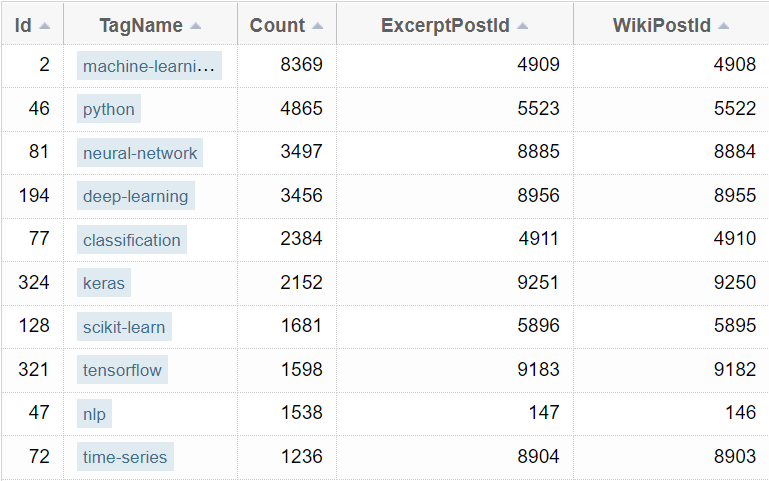

From the above output we can see that machine learning is by far the most popular topic, however the majority of tags in the top 10 are sub-topics of machine learning. The only exceptions are python, and time-series.





Having reviewed the schema and inspected the database, the following properties appear interesting for learning about how users interact with the site:

- Post Creation Date
- Post View Count
- Post Answer Count
- Post Favorite Count
- Post Score
- Tags
- Post TypeId - An Id for the post as an integer: 
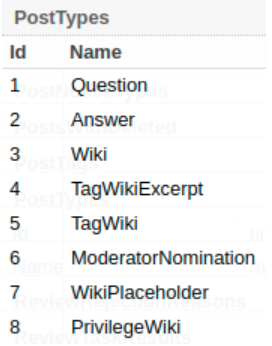





**Getting the Data**

The following query confirms that the vast majority of posts are either a question or answer:

SELECT PostTypeId, COUNT(*) as NumberOfPosts

FROM Posts

GROUP BY PostTypeId

ORDER BY COUNT(*) DESC;

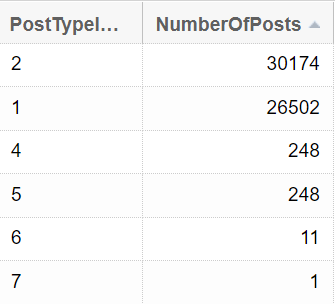

As we are only interested in recent posts, we will run a query to return 2020 data and export so we can work with it in python. The following query produces the data we will work with:

SELECT

  Id, 

  PostTypeId, 
  
  CreationDate, 
  
  Score, 
  
  ViewCount, 
  
  Tags,
  
  AnswerCount,
  
  FavoriteCount

FROM Posts

WHERE PostTypeId = 1 

AND YEAR(CreationDate) = 2019;

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving QueryResults (1).csv to QueryResults (1).csv


In [ ]:
import pandas as pd
import io
df = pd.read_csv(io.StringIO(uploaded['QueryResults (1).csv'].decode('utf-8')))
df.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,66154,1,2020-01-09 05:44:03,2,113,<python><decision-trees><jupyter><image><anaco...,2,NaN
1,66159,1,2020-01-09 07:18:26,1,61,<machine-learning><decision-trees><data-scienc...,1,NaN
2,66160,1,2020-01-09 07:40:32,12,138,<clustering><k-means><kernel><spectral-cluster...,1,NaN
3,66161,1,2020-01-09 07:45:24,0,33,<machine-learning><keras><tensorflow><computer...,0,NaN
4,66162,1,2020-01-09 08:07:18,1,63,<machine-learning>,1,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7595 entries, 0 to 7594
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             7595 non-null   int64  
 1   PostTypeId     7595 non-null   int64  
 2   CreationDate   7595 non-null   object 
 3   Score          7595 non-null   int64  
 4   ViewCount      7595 non-null   int64  
 5   Tags           7595 non-null   object 
 6   AnswerCount    7595 non-null   int64  
 7   FavoriteCount  901 non-null    float64
dtypes: float64(1), int64(5), object(2)
memory usage: 474.8+ KB


The dataframe contains 7,594 rows. Only the `FavoriteCount` column contains null values.

Let's explore further to determine next steps.

In [ ]:
df.describe()

,Id,PostTypeId,Score,ViewCount,AnswerCount,FavoriteCount
count,7595.000000,7595.0,7595.000000,7595.000000,7595.000000,901.000000
mean,76052.571560,1.0,0.828440,109.497038,0.760237,1.138735
std,6363.700109,0.0,1.433517,448.767336,0.805596,0.900406
min,65678.000000,1.0,-4.000000,2.000000,0.000000,0.000000
25%,70212.000000,1.0,0.000000,19.000000,0.000000,1.000000
50%,75571.000000,1.0,0.000000,32.000000,1.000000,1.000000
75%,81349.500000,1.0,1.000000,61.000000,1.000000,1.000000
max,87187.000000,1.0,34.000000,17045.000000,10.000000,10.000000


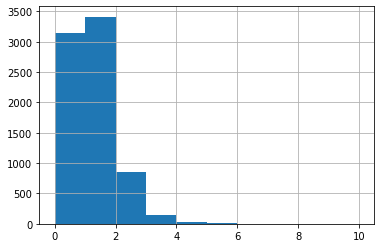

In [ ]:
df['AnswerCount'].hist()

The above data exploration highlights the following for each column:

- `Score` - the range can enter into minus numbers (min = -6), and has an outlier of 238, given a standard deviation of around 5 from a mean of almost 2. As we are interested in popular posts we can exclude any post with a score below 0.

- `ViewCount` - has a large range (from 2 to 17045 views, STD of 448), and some outliers (75% are up to 61). Again we may wish to discount posts with low views i.e.  less than 100. 

- `AnswerCount` - approximately 6,500 posts received less than 2 answers. 

- `CreationDate` - this is an object dtype, which we will need to convert in order to analyse for any patterns such as correlation between time or day of post and number of views and answers.

- `Tags` - this column needs cleaning as it currently contains all tags associated with each post. 

In [ ]:
#Tidying the columns by filling blanks and converting data types
df.fillna(0, inplace=True)
df[['ViewCount', 'AnswerCount','FavoriteCount']] = df[['ViewCount', 'AnswerCount','FavoriteCount']].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7595 entries, 0 to 7594
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             7595 non-null   int64 
 1   PostTypeId     7595 non-null   int64 
 2   CreationDate   7595 non-null   object
 3   Score          7595 non-null   int64 
 4   ViewCount      7595 non-null   int64 
 5   Tags           7595 non-null   object
 6   AnswerCount    7595 non-null   int64 
 7   FavoriteCount  7595 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 474.8+ KB


In [ ]:
from datetime import datetime
df['CreationDate'] = pd.to_datetime(df['CreationDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7595 entries, 0 to 7594
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             7595 non-null   int64         
 1   PostTypeId     7595 non-null   int64         
 2   CreationDate   7595 non-null   datetime64[ns]
 3   Score          7595 non-null   int64         
 4   ViewCount      7595 non-null   int64         
 5   Tags           7595 non-null   object        
 6   AnswerCount    7595 non-null   int64         
 7   FavoriteCount  7595 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 474.8+ KB


In [ ]:
df['Tags'].head()

0    <python><decision-trees><jupyter><image><anaco...
1    <machine-learning><decision-trees><data-scienc...
2    <clustering><k-means><kernel><spectral-cluster...
3    <machine-learning><keras><tensorflow><computer...
4                                   <machine-learning>
Name: Tags, dtype: object

In [ ]:
df['Tags'] = df['Tags'].str.replace("^<|>$", "").str.split("><")
df['Tags'].head()

0    [python, decision-trees, jupyter, image, anaco...
1    [machine-learning, decision-trees, data-scienc...
2    [clustering, k-means, kernel, spectral-cluster...
3    [machine-learning, keras, tensorflow, computer...
4                                   [machine-learning]
Name: Tags, dtype: object

**Most Used and Most Viewed**

Now the data has been cleaned we will determine the most popular tags. For each tag we will count how many times it was used, and how many times a question with that tag was viewed.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
tag_count = dict()
for tags in df['Tags']:
  for tag in tags:
    if tag in tag_count:
      tag_count[tag] += 1
    else:
      tag_count[tag] = 1

In [ ]:
views_per_tag = dict()

for index, row in df.iterrows():
  for tag in row['Tags']:
    if tag in views_per_tag:
      views_per_tag[tag] += row['ViewCount']
    else:
      views_per_tag[tag] = row['ViewCount']

In [ ]:
tag_count = pd.DataFrame.from_dict(tag_count, orient='index').reset_index()
views_per_tag = pd.DataFrame.from_dict(views_per_tag, orient='index').reset_index()

In [ ]:
tag_count.rename(columns={'index': 'tag', 0: 'count'}, inplace=True)
views_per_tag.rename(columns={'index': 'tag', 0: 'views'}, inplace=True)
print(tag_count.head(), '\n', views_per_tag.head())

              tag  count
0          python   1430
1  decision-trees    167
2         jupyter     36
3           image     30
4        anaconda     18 
               tag   views
0          python  223733
1  decision-trees   17152
2         jupyter   14676
3           image    1340
4        anaconda    7918


In [ ]:
top_tags = tag_count.sort_values('count', ascending=False).head(20)
top_views = views_per_tag.sort_values('views', ascending=False).head(20)

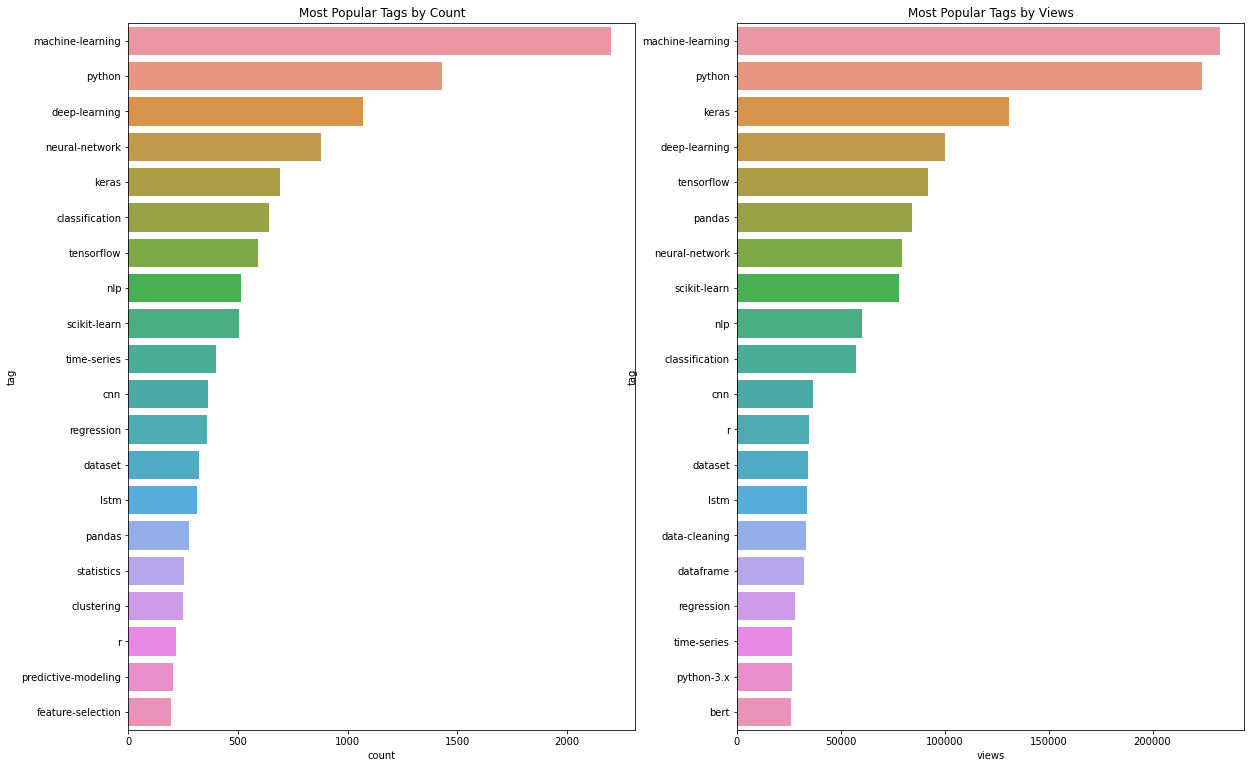

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,13))
sns.barplot(x=top_tags['count'], y=top_tags['tag'], ax=ax[0])
ax[0].set_title('Most Popular Tags by Count')
sns.barplot(x=top_views['views'], y=top_views['tag'], ax=ax[1])
ax[1].set_title('Most Popular Tags by Views')
plt.show()

The above horizontal bar plots visualise the count of the 20 most popular tags, first by count on the site and second by number of views. Some of these are quite generic e.g. `r`, `python`, `statistics` and perhaps worth exploring further. 

**Relationship between tags**

Now we will look at potential relationships between tags, for example we know that pandas is a python library so any questions tagged as pandas should also be considered a python question. 

We will start by looking at which tags are missing from the two dataframes containing the top 20 tags by count and views.

In [ ]:
in_top_tags = pd.merge(top_tags, top_views, how='left')
in_top_tags

,tag,count,views
0,machine-learning,2201,232485.0
1,python,1430,223733.0
2,deep-learning,1068,100183.0
3,neural-network,877,79252.0
4,keras,692,130811.0
5,classification,643,57100.0
6,tensorflow,591,91845.0
7,nlp,513,60109.0
8,scikit-learn,503,77864.0
9,time-series,398,26343.0


In [ ]:
in_top_views = pd.merge(top_views, top_tags, how='left')
in_top_views

,tag,views,count
0,machine-learning,232485,2201.0
1,python,223733,1430.0
2,keras,130811,692.0
3,deep-learning,100183,1068.0
4,tensorflow,91845,591.0
5,pandas,84083,277.0
6,neural-network,79252,877.0
7,scikit-learn,77864,503.0
8,nlp,60109,513.0
9,classification,57100,643.0


The following tags are in the top_tags dataframe but missing from top_views:

- Statistics
- Clustering
- Predictive Modelling
- Feature Selection

The tags below are in top_views but not in top_tags:

- Data Cleaning
- Dataframe
- Python 3.x
- Bert

In [ ]:
#Looking at proportion of questions tagged as both 'python' and 'machine-learning'
df[df['Tags'].apply(lambda tags: True if 'python' and 'machine-learning' in tags else False)]

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
1,66159,1,2020-01-09 07:18:26,1,61,"[machine-learning, decision-trees, data-scienc...",1,0
3,66161,1,2020-01-09 07:45:24,0,33,"[machine-learning, keras, tensorflow, computer...",0,0
4,66162,1,2020-01-09 08:07:18,1,63,[machine-learning],1,0
13,66183,1,2020-01-09 10:36:22,1,24,"[machine-learning, training, hyperparameter-tu...",1,0
14,66188,1,2020-01-09 11:36:14,2,122,"[machine-learning, random-forest, matplotlib, ...",2,0
...,...,...,...,...,...,...,...,...
7579,87156,1,2020-12-26 13:50:15,1,24,"[machine-learning, nlp, machine-learning-model...",1,0
7580,87157,1,2020-12-26 13:56:16,0,13,"[machine-learning, deep-learning, cnn, object-...",0,0
7584,87162,1,2020-12-26 15:31:52,1,13,"[machine-learning, python, regression, linear-...",2,0
7591,87184,1,2020-12-26 23:08:41,1,6,"[machine-learning, python, supervised-learning]",0,0


In [ ]:
all_tags = list(tag_count['tag'])
associations = pd.DataFrame(index=all_tags, columns=all_tags)
associations.iloc[0:5,0:5]

,python,decision-trees,jupyter,image,anaconda
python,NaN,NaN,NaN,NaN,NaN
decision-trees,NaN,NaN,NaN,NaN,NaN
jupyter,NaN,NaN,NaN,NaN,NaN
image,NaN,NaN,NaN,NaN,NaN
anaconda,NaN,NaN,NaN,NaN,NaN


Above we created an empty dataframe with the index and columns set to tags. We can fill this dataframe with zeroes and then increment each value for each question which uses tags in both the index and columns.

In [ ]:
associations.fillna(0, inplace=True)

for tags in df['Tags']:
  associations.loc[tags, tags] += 1

In [ ]:
#Viewing the first 5 rows
associations.iloc[0:5,0:5]

,python,decision-trees,jupyter,image,anaconda
python,1430,20,24,5,10
decision-trees,20,167,1,1,1
jupyter,24,1,36,1,4
image,5,1,1,30,1
anaconda,10,1,4,1,18


As the dataset is quite large, making it difficult to quickly visualise relationships. To help with this, let's reduce the `associations` dataframe to the top 20 tags (by `count`) and then display a heatmap. 

In [ ]:
associations.head()

,python,decision-trees,jupyter,image,anaconda,machine-learning,data-science-model,adaboost,clustering,k-means,kernel,spectral-clustering,keras,tensorflow,computer-vision,classification,dimensionality-reduction,binary,tsne,rnn,deep-learning,nlp,data,stanford-nlp,dataset,correlation,matrix,accuracy,similarity,lsi,activation-function,training,hyperparameter-tuning,random-forest,matplotlib,gridsearchcv,explainable-ai,multiclass-classification,neural-network,image-recognition,...,rmsprop,functional-api,bayes-error,software-development,genetic-programming,gnn,anonymization,federated-learning,concept-drift,community,kendalls-tau-coefficient,dynamic-programming,state-of-the-art,anomaly,octave,validation,aws-lambda,programming,wolfram-language,dirichlet,graphviz,averagepooling1d,genetic,relational-dbms,history,mlops,spatial-transformer,metadata,continuos,discreet,ibm-watson,baum-welch,goodness-of-fit,r-squared,apache-mahout,entity-linking,dynamic-time-warping,cregression,acf,pacf
python,1430,20,24,5,10,386,34,3,53,28,8,1,187,136,24,93,3,1,2,9,125,82,23,1,40,15,5,9,10,2,2,18,9,41,31,9,3,21,85,10,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
decision-trees,20,167,1,1,1,61,7,3,2,0,0,0,0,0,0,22,0,0,0,0,1,0,0,0,1,2,0,4,0,0,0,0,1,29,0,2,5,4,7,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
jupyter,24,1,36,1,4,2,0,0,1,0,2,0,2,3,1,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
image,5,1,1,30,1,5,0,0,0,0,0,0,4,3,3,1,0,0,0,0,7,0,1,0,2,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
anaconda,10,1,4,1,18,1,0,0,1,0,0,0,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Filtering down to top 20 tags by count
most_common_relations = associations.loc[top_tags['tag'], top_tags['tag']]
most_common_relations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, machine-learning to feature-selection
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   machine-learning     20 non-null     int64
 1   python               20 non-null     int64
 2   deep-learning        20 non-null     int64
 3   neural-network       20 non-null     int64
 4   keras                20 non-null     int64
 5   classification       20 non-null     int64
 6   tensorflow           20 non-null     int64
 7   nlp                  20 non-null     int64
 8   scikit-learn         20 non-null     int64
 9   time-series          20 non-null     int64
 10  cnn                  20 non-null     int64
 11  regression           20 non-null     int64
 12  dataset              20 non-null     int64
 13  lstm                 20 non-null     int64
 14  pandas               20 non-null     int64
 15  statistics           20 non-null     int64
 16  clu

In [ ]:
import numpy as np
for i in range(most_common_relations.shape[0]):
  most_common_relations.iloc[i,i] = pd.np.NaN

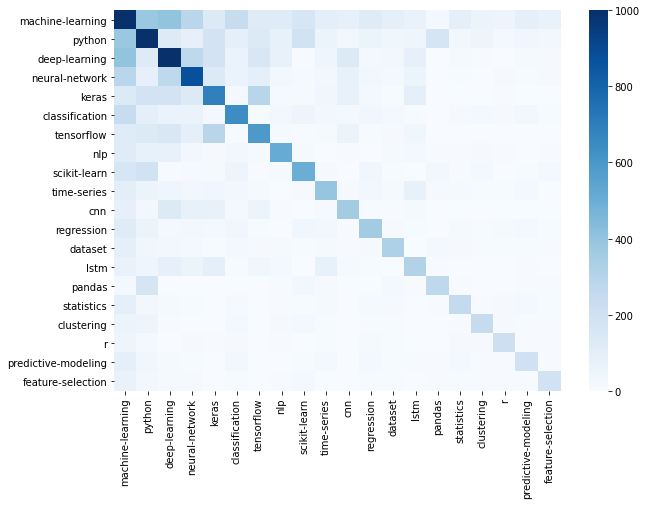

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(most_common_relations, cmap='Blues', vmax=1000)
#vmax set at 1000 otherwise the map is skewed by machine-learning and makes it difficult to see relationships

The heatmap above shows the following tags have relationships:
- `machine-learning` has strong relationships with `python`, `deep-learning`, a moderate relationship with `classification` and a weak relationships with `scikit-learn` along with several other tags. 
- `deep-learning` has weak to moderate relationships with `neural-network`, `keras`, `tensorflow`, `cnn` and `ltsm`

**Domain Knowledge and Final Recommendation**

Given our domain knowledge about data science, it would have been reasonable to predict relationships between some of the tags e.g. between `machine-learning`, `deep-learning`, `scikit-learn`, `classification`, `tensorflow`, `keras`, `cnn`, `lstm`, `clustering`, `regression` and `feature-selection`. 

However, it is still important to analyse the data rather than simply rely on our assumptions. 

Given we want the content we produce to be relevant for as long as possible, we should undertake one final analysis to look at popularity of topics over a longer time span rather than only 2020. This helps to provide reassurance that the topic we focus on is not simply a fad! The following query will return the data we require:

SELECT `Id`, `CreationDate`, `Tags`

FROM `Posts`

WHERE `PostTypeId` = 1


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving QueryResults (2).csv to QueryResults (2).csv


In [ ]:
df2 = pd.read_csv(io.StringIO(uploaded['QueryResults (2).csv'].decode('utf-8')))
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26502 entries, 0 to 26501
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            26502 non-null  int64 
 1   CreationDate  26502 non-null  object
 2   Tags          26502 non-null  object
dtypes: int64(1), object(2)
memory usage: 621.3+ KB


In [ ]:
df2['CreationDate'] = pd.to_datetime(df2['CreationDate'])

As `machine-learning` was the most popular tag in our 2020 dataset, we will focus on this topic for our analysis. However, we know that other tags are related to the application of `machine-learning` and we will therefore include the following also within our analysis:

`deep-learning`, `keras`, `classification`, `tensorflow`, `scikit-learn`, `cnn`, `regression`, `lstm`, and `clustering`.

In [ ]:
def class_machine_learning(tags):
  for tag in tags:
    if tag in ['machine-learning', 'deep-learning', 'keras', 'classification', 'tensorflow',
               'scikit-learn', 'cnn', 'regression', 'lstm', 'clustering']:
               return 1
  return 0

In [ ]:
df2['machine_learning'] = df2['Tags'].apply(class_machine_learning)
df2.sample(5)

,Id,CreationDate,Tags,machine_learning
6428,38007,2018-09-09 18:08:57,[nlp],0
200,75429,2020-06-04 04:02:15,[tableau],0
12120,80250,2020-08-13 21:34:05,"[python, regression, cross-validation, overfit...",1
17053,53852,2019-06-15 15:16:00,"[neural-network, deep-learning, keras, tensorf...",1
21343,65783,2020-01-03 09:54:04,"[computer-vision, pytorch, transfer-learning]",0


The above function has classified each post as `machine_learning` with a 1 in the respective column, or 0 if none of the relevant tags are in the `Tags` column. 

Now we can answer a couple of questions:

- How many `machine-learning` questions are asked per time period (we will segment by quarters)?
- Total amount of questions per quarter?
- Ratio of `machine-learning` questions to total questions asked per quarter?

In [ ]:
def return_quarter(datetime):
  year = str(datetime.year)[-2:]
  quarter = str(((datetime.month-1) // 3) + 1)
  return "{y}Q{q}".format(y=year, q=quarter)

df2['Quarter'] = df2['CreationDate'].apply(return_quarter)

In [ ]:
df2.head()

,Id,CreationDate,Tags,machine_learning,Quarter
0,13692,2016-08-26 10:45:55,"[neural-network, predictive-modeling]",0,16Q3
1,13694,2016-08-26 13:13:06,"[apache-spark, apache-hadoop, association-rules]",0,16Q3
2,13695,2016-08-26 14:16:14,"[machine-learning, recommender-system, aws]",1,16Q3
3,13696,2016-08-26 15:29:46,[neural-network],0,16Q3
4,13701,2016-08-26 18:03:38,"[apache-spark, scala, market-basket-analysis]",0,16Q3


In [ ]:
quarterly = df2.groupby('Quarter').agg({'machine_learning': ['sum', 'size']})
quarterly.columns = ['Machine_Learning_Questions', 'Total_Questions']
quarterly['Machine_Learning_Ratio'] = quarterly['Machine_Learning_Questions'] / quarterly['Total_Questions']
quarterly.reset_index(inplace=True)
quarterly.sample(5)

,Quarter,Machine_Learning_Questions,Total_Questions,Machine_Learning_Ratio
23,20Q1,1234,2044,0.603718
14,17Q4,569,888,0.640766
16,18Q2,910,1426,0.638149
18,18Q4,783,1269,0.617021
10,16Q4,299,520,0.575000


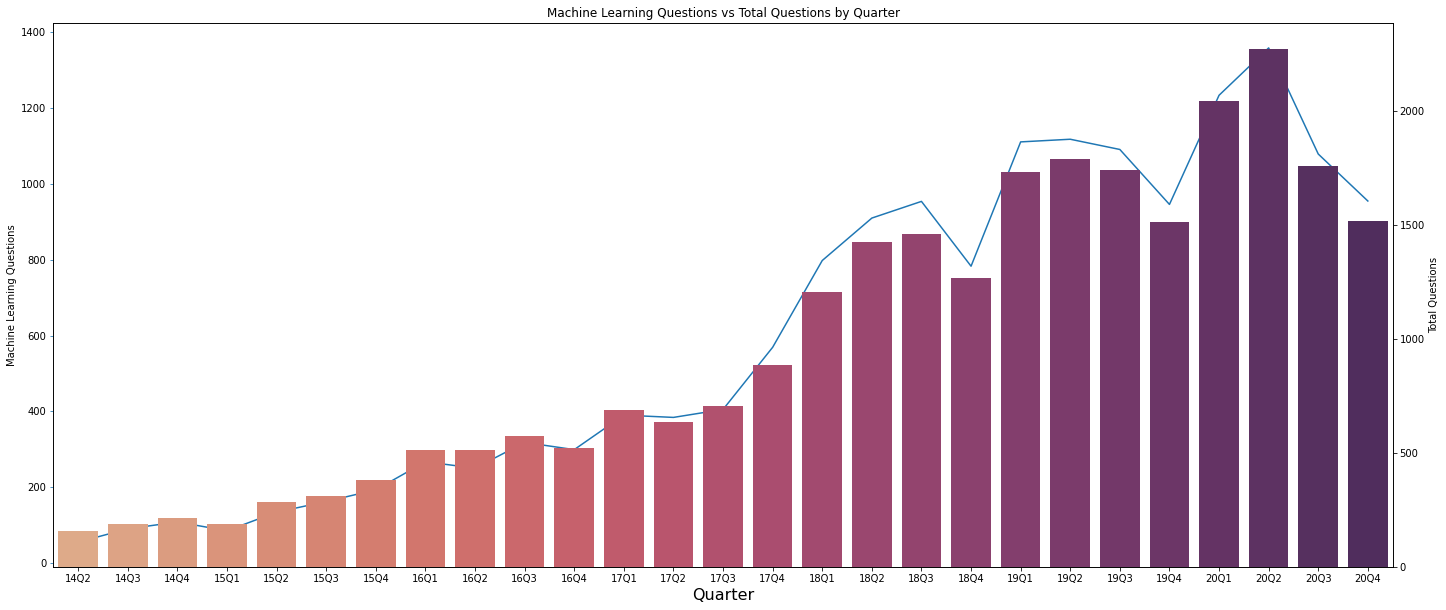

In [ ]:
fig, ax1 = plt.subplots(figsize=(24,10))
ax1 = sns.lineplot(x='Quarter', y='Machine_Learning_Questions', data=quarterly, markers=True)
ax1.set_title('Machine Learning Questions vs Total Questions by Quarter')
ax1.set_xlabel('Quarter', fontsize=16)
ax1.set_ylabel('Machine Learning Questions')
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
ax2 = sns.barplot(x='Quarter', y='Total_Questions', data=quarterly, palette='flare')
ax2.set_ylabel('Total Questions')
ax2.tick_params(axis='y')
plt.show()

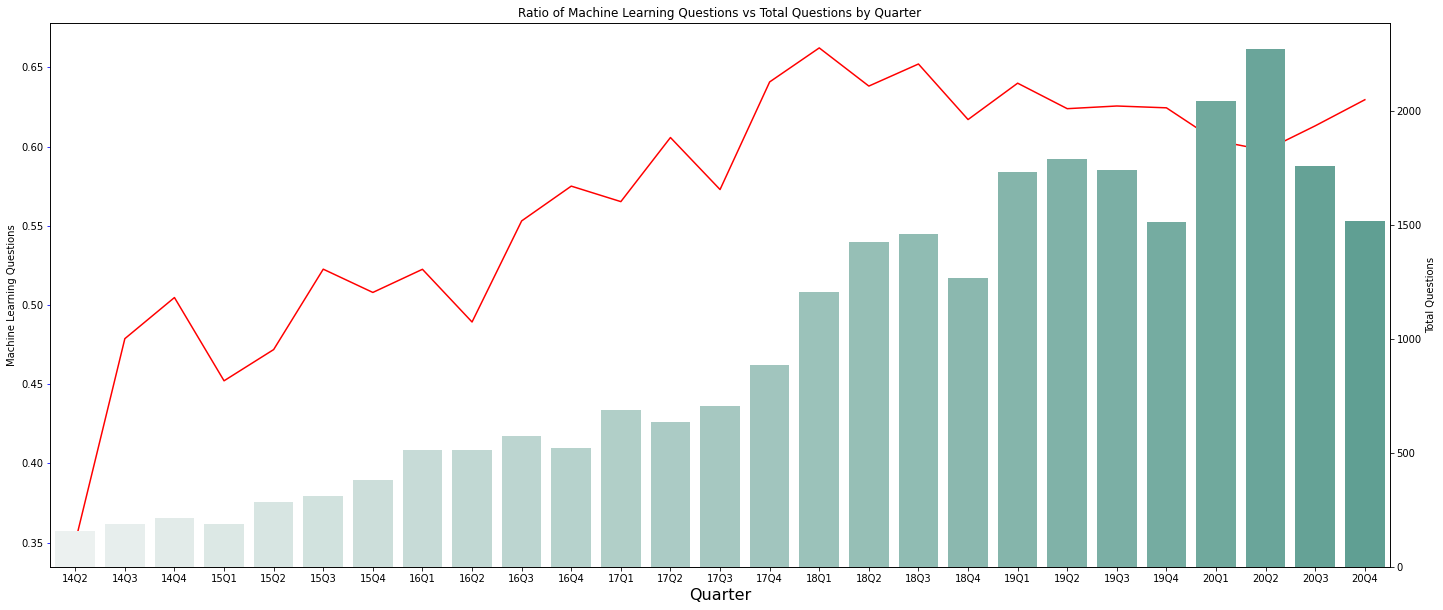

In [ ]:
fig, ax1 = plt.subplots(figsize=(24,10))
ax1 = sns.lineplot(x='Quarter', y='Machine_Learning_Ratio', data=quarterly, markers=True, color='r')
ax1.set_title('Ratio of Machine Learning Questions vs Total Questions by Quarter')
ax1.set_xlabel('Quarter', fontsize=16)
ax1.set_ylabel('Machine Learning Questions')
ax1.tick_params(axis='y', color='blue')

ax2 = ax1.twinx()
ax2 = sns.barplot(x='Quarter', y='Total_Questions', data=quarterly, palette='light:#5A9')
ax2.set_ylabel('Total Questions')
ax2.tick_params(axis='y')
plt.show()

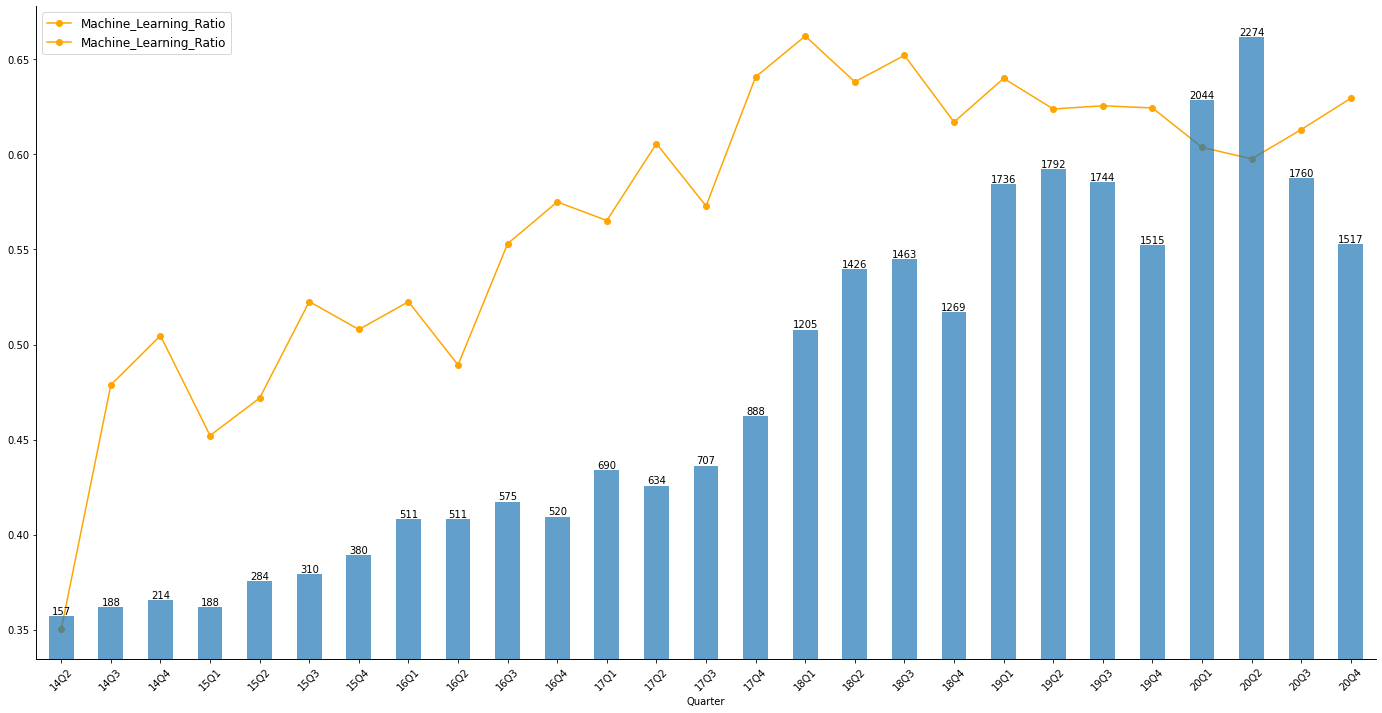

In [ ]:
ax1 = quarterly.plot(x='Quarter', y='Machine_Learning_Ratio', kind='line',
                     linestyle='-', color='orange', marker='o', figsize=(24,12))
ax2 = quarterly.plot(x='Quarter', y='Total_Questions', kind='bar', ax=ax1, secondary_y=True,
                     alpha=0.7, rot=45)

for idx, t in quarterly['Total_Questions'].iteritems():
  ax2.text(idx, t, str(t), ha='center', va='bottom')
xlims = ax1.get_xlim()
ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2,
           labels = labels1 + labels2,
           loc='upper left', prop={'size': 12})

for ax in (ax1, ax2):
  for where in ('top', 'right'):
    ax.spines[where].set_visible(False)
    ax.tick_params(right=False, labelright=False)

After playing around with different visualisations, we can comfortably conclude that `machine-learning` is remaining consistently popular as a topic and is therefore suitable for our content. 

This is as far as we will go, however some options for further analysis could include:

- Repeating these steps with other tags to try and identify topics gaining popularity
- Running another analysis without the grouping of tags, to see if any are popular enough of their own accord to justify the development of content relating to those topics